<a href="https://colab.research.google.com/github/chaehoon1/HAI_summer_assignment25/blob/main/HAI_summer_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset 정의

In [39]:
import torch.utils.data as data
import glob
import PIL
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor

def getCropImg(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor()
    ])

def getLRimage(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size//upscale_factor, PIL.Image.BICUBIC),
        Resize(crop_size, PIL.Image.BICUBIC),
        ToTensor()
    ])

class MyDataset(data.Dataset):
    def __init__(self, image_dir, start, end):
        super(MyDataset, self).__init__()
        self.png_files = glob.glob(image_dir + "*.png")
        self.png_files = sorted(self.png_files)
        self.png_files = self.png_files[start:end]

        self.input_transform = getLRimage(64, 2)
        self.target_transform = getCropImg(64)

    def __getitem__(self, index):
        input = PIL.Image.open(self.png_files[index])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target


    def __len__(self):
        return len(self.png_files)

Model 정의

In [40]:
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        self.layer1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size = 9, stride = 1, padding = 4),
                nn.ReLU())

        self.layer2 = nn.Sequential(
                nn.Conv2d(64, 32, kernel_size = 1, stride = 1, padding = 0),
                nn.ReLU())

        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 3, kernel_size = 5, stride = 1, padding = 2))

    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        return x

Model 학습시키기

In [41]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SRCNN().to(device)

epochs = 50
batch_size = 32
lr = 0.001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trainDataNum, validDataNum, testDataNum = 363, 104, 52
train_set = MyDataset('/content/drive/MyDrive/DIV2K_HR_519sampled/', 0, trainDataNum)
valid_set = MyDataset('/content/drive/MyDrive/DIV2K_HR_519sampled/', trainDataNum, trainDataNum + validDataNum)
test_set = MyDataset('/content/drive/MyDrive/DIV2K_HR_519sampled/', trainDataNum + validDataNum, trainDataNum + validDataNum + testDataNum)
training_data_loader = DataLoader(dataset=train_set, batch_size=batch_size , shuffle=True)
valid_data_loader = DataLoader(dataset=valid_set, batch_size=batch_size , shuffle=False)
test_data_loader = DataLoader(dataset=test_set, batch_size=batch_size , shuffle=False)

for epoch in range(epochs):
  for i, batch in enumerate(training_data_loader):
    input, target = batch[0].to(device), batch[1].to(device)
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
      for i, batch in enumerate(valid_data_loader):
          input, target = batch[0].to(device), batch[1].to(device)
          output = model(input)
          loss = loss_fn(output, target)
          val_loss += loss.item()

  avg_val_loss = val_loss / len(valid_data_loader)
  print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

Epoch [1/50], Validation Loss: 0.0357
Epoch [2/50], Validation Loss: 0.0222
Epoch [3/50], Validation Loss: 0.0169
Epoch [4/50], Validation Loss: 0.0126
Epoch [5/50], Validation Loss: 0.0096
Epoch [6/50], Validation Loss: 0.0079
Epoch [7/50], Validation Loss: 0.0066
Epoch [8/50], Validation Loss: 0.0060
Epoch [9/50], Validation Loss: 0.0053
Epoch [10/50], Validation Loss: 0.0047
Epoch [11/50], Validation Loss: 0.0043
Epoch [12/50], Validation Loss: 0.0041
Epoch [13/50], Validation Loss: 0.0039
Epoch [14/50], Validation Loss: 0.0037
Epoch [15/50], Validation Loss: 0.0036
Epoch [16/50], Validation Loss: 0.0035
Epoch [17/50], Validation Loss: 0.0034
Epoch [18/50], Validation Loss: 0.0034
Epoch [19/50], Validation Loss: 0.0034
Epoch [20/50], Validation Loss: 0.0036
Epoch [21/50], Validation Loss: 0.0036
Epoch [22/50], Validation Loss: 0.0033
Epoch [23/50], Validation Loss: 0.0032
Epoch [24/50], Validation Loss: 0.0031
Epoch [25/50], Validation Loss: 0.0031
Epoch [26/50], Validation Loss: 0.

모델 저장 및 불러오기

In [43]:
torch.save(model.state_dict(), "srcnn_checkpoint.pth")

new_model = SRCNN().to(device)
new_model.load_state_dict(torch.load("srcnn_checkpoint.pth"))
new_model.eval()

SRCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

결과

In [44]:
import os

save_dir = "/content/SR_outputs/"
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
    for idx, batch in enumerate(test_data_loader):
        inputs, targets = batch[0].to(device), batch[1].to(device)
        outputs = new_model(inputs)

        for i in range(outputs.size(0)):
            output_img = outputs[i].cpu().clamp(0, 1)
            save_path = os.path.join(save_dir, f"SR_output_{idx * test_data_loader.batch_size + i + 1}.png")
            F.to_pil_image(output_img).save(save_path)

시각화

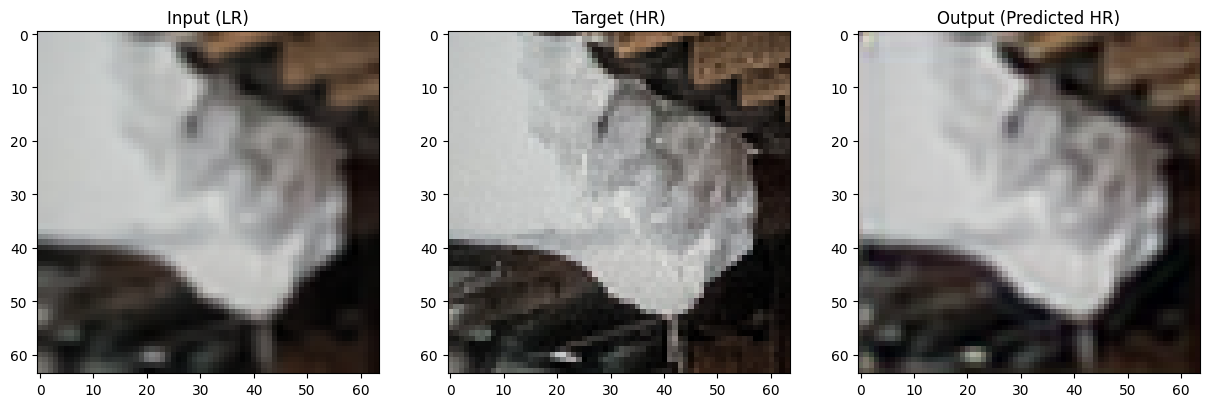

In [45]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

input, target = test_set[30]
output = model(input.unsqueeze(0).to(device))
output = output.squeeze(0).cpu().detach()
output = output.clamp(0.0, 1.0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(F.to_pil_image(input))
plt.title("Input (LR)")

plt.subplot(1, 3, 2)
plt.imshow(F.to_pil_image(target))
plt.title("Target (HR)")

plt.subplot(1, 3, 3)
plt.imshow(F.to_pil_image(output))
plt.title("Output (Predicted HR)")

plt.show()
